# 1. Importing libraries

In [2]:
# Data processing  
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Pandas options  
# -----------------------------------------------------------------------
pd.options.display.max_colwidth = None

# Path configuration for custom module imports
# -----------------------------------------------------------------------
import sys
sys.path.append('../')

# Ignore warnings  
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Clusters and metrics
# -----------------------------------------------------------------------
from yellowbrick.cluster import KElbowVisualizer

# Clustering models
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# Custom functions and classes
# -----------------------------------------------------------------------
from src.preprocess import preprocess
from src.circuit_clustering_model.clustering import * # Fix this
from src.circuit_clustering_model.clustering import plot_clusters, plot_radar, plot_cluster_scatter, get_pca



# 2. Data loading

We loaded the original circuits dataset and the dataset with feature engineering. Both datasets are clean and free of duplicates.

In [3]:
df_original = pd.read_csv('../data/output/circuits_complete.csv', index_col=0)

df_original.head()

,laptime,max_speed,distance,n_corners,avg_corner_speed,avg_speed,straight_length,gear_changes,n_slow_corners,n_medium_corners,n_fast_corners,n_gear1_corners,n_gear2_corners,n_gear3_corners,n_gear4_corners,n_gear5_corners,n_gear6_corners,n_gear7_corners,n_gear8_corners
hockenheimring,71.767,320.0,4568.748333,17,209.960540,229.888136,1663.919441,40.0,3,9,5,0,1,3,1,3,5,3,1
nurburgring,85.269,318.0,5112.340000,15,173.563856,216.201705,2043.790918,50.0,5,7,3,0,0,4,3,3,1,2,1
portimao,77.968,314.0,4637.664722,15,188.740533,214.136223,1800.793691,40.0,4,5,6,0,0,4,2,1,4,4,0
sochi,101.993,291.0,5789.306111,18,172.024977,204.520095,1284.998104,64.0,5,8,5,0,3,7,2,1,1,3,1
istanbul,82.868,321.0,5253.130833,14,176.854350,228.286957,3877.396258,39.0,3,8,3,0,3,1,4,1,0,2,1


In [4]:
df_featured = pd.read_csv('../data/output/featured_circuits_complete.csv', index_col=0)

df_featured.head()

,max_speed,distance,avg_corner_speed,avg_speed,short_gear_corners_prop,long_gear_corners_prop,slow_corners_prop,medium_corners_prop,fast_corners_prop,straight_prop,gear_changes_per_km,n_corners_per_km
hockenheimring,320.0,4568.748333,209.960540,229.888136,0.294118,0.705882,0.176471,0.529412,0.294118,0.364196,8.755133,3.720932
nurburgring,318.0,5112.340000,173.563856,216.201705,0.466667,0.466667,0.333333,0.466667,0.200000,0.399776,9.780257,2.934077
portimao,314.0,4637.664722,188.740533,214.136223,0.400000,0.600000,0.266667,0.333333,0.400000,0.388298,8.625031,3.234386
sochi,291.0,5789.306111,172.024977,204.520095,0.666667,0.333333,0.277778,0.444444,0.277778,0.221961,11.054865,3.109181
istanbul,321.0,5253.130833,176.854350,228.286957,0.571429,0.285714,0.214286,0.571429,0.214286,0.738111,7.424144,2.665077


We will use the dataset with feature engineering for clustering since its variables can be more meaningful.

# 3. Preprocessing  

To carry out the preprocessing, we need to evaluate the following aspects:  

* Remove the columns we do not want to consider:
    - In this case, we do not need to remove any columns since the datasets are already prepared for preprocessing.  

* Select the encoding methods for categorical variables:
    - We do not have categorical variables, so we do not need to perform `encoding`.  

* Select the scaling method: 
    - Since we have very few outliers in our datasets and there are no extremely high values, we will use a `MinMax` scaler.


In [5]:
encoding_methods = {}
scaling = 'minmax'

df_encoded, df_scaled = preprocess(df_featured, encoding_methods, scaling)

In [110]:
df_scaled.to_csv('../data/preprocessed/circuits_scaled.csv')

# 4. Clustering

## 4.1 K-means

We have the following columns/features available:

- `max_speed`: The maximum speed reached on the circuit.

- `distance`: The total length of the circuit measured in kilometers.

- `avg_corner_speed`: The average speed of the car through the corners apex on the circuit.

- `avg_speed`: The overall average speed of the car over the entire circuit.

- `short_gear_corners_prop`: The proportion of corners on the track where cars need to use shorter gears (1 to 4).

- `long_gear_corners_prop`: The proportion of corners that require longer gears (5 to 8).

- `slow_corners_prop`: The percentage of corners on the circuit that are classified as slow (less than 120 kph).

- `medium_corners_prop`: The proportion of corners that are of medium speed (from 120 to 240 kph).

- `fast_corners_prop`: The percentage of corners on the track that are classified as fast (more than 240 kph).

- `straight_prop`: The proportion of the circuit that consists of straight sections (more than 500 m).

- `gear_changes_per_km`: The average number of gear shifts the car makes per kilometer on the circuit.

- `n_corners_per_km`: The number of corners per kilometer.

### 4.1.1 Selection of Variables for Circuit Clustering

To perform an effective segmentation of the circuits, it is essential to choose variables that meaningfully represent their distinctive characteristics. In this case, we have selected `avg_speed` (average speed), `straight_prop` (proportion of straights), and `slow_corners_prop` (proportion of slow corners), as these variables capture key aspects of each circuit's layout.

Using a limited set of variables helps avoid issues related to high dimensionality, especially given that our dataset is not very large. Including too many variables could dilute the definition of the clusters and make segmentation less clear. However, in future iterations, we could test additional variables, and evaluate their impact on cluster cohesion using dimensionality reduction techniques like `PCA` or `feature importance` metrics.


In [6]:
cols = ['avg_speed', 'straight_prop', 'slow_corners_prop']

df_kmeans = df_scaled[cols]

### 4.1.2 Number of clusters

We will initialize a `K-Means` model and use the `Silhouette Score` as a criterion to determine the optimal number of clusters. This approach allows us to assess which number of groups provides the best cohesion and separation within the data.


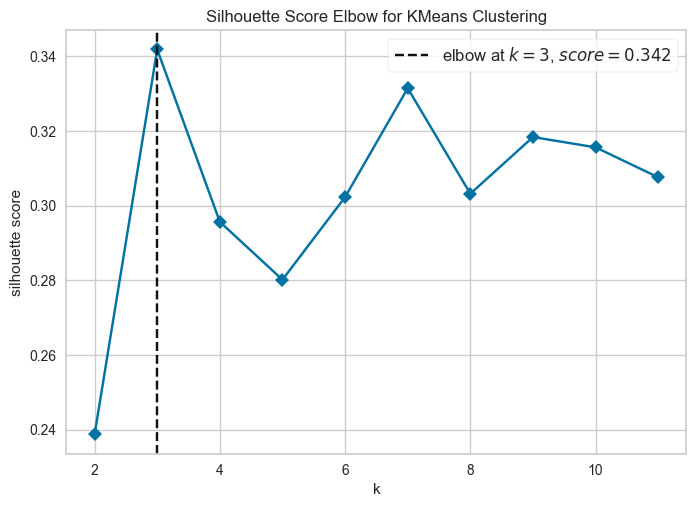

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
model = KMeans(random_state=42)

visualizer = KElbowVisualizer(model, k=(2, 12), metric="silhouette", timings=False)
visualizer.fit(df_kmeans)
visualizer.show()

The `elbow method` suggests that an appropriate number of clusters could be 3. However, Formula 1 circuits have significant differences, making a segmentation into only three groups too general. For this reason, we will select the next best option identified, which corresponds to `7 clusters`, allowing for a more detailed differentiation between the various types of circuits.

### 4.1.3 Metrics

In [8]:
model_kmeans = KMeans(n_clusters=7, random_state=42)

km_fit = model_kmeans.fit(df_kmeans)
labels = km_fit.labels_

clustering_metrics(df_kmeans, labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.331412,0.688945,3
1,0.331412,0.688945,4
2,0.331412,0.688945,7
3,0.331412,0.688945,2
4,0.331412,0.688945,10
5,0.331412,0.688945,3
6,0.331412,0.688945,1


To validate our choice, we analyzed multiple feature combinations and different numbers of clusters, evaluating their quality using the following metrics:  
- `Silhouette Score`: 0.331412  
- `Davies-Bouldin Index`: 0.688945  

These values represent some of the best metrics obtained in our experiments, ensuring a balance between cohesion, separation, and interpretability. 

While we could optimize the metrics further with more clusters, we prioritize a segmentation that remains interpretable and meaningfully reflects circuit differences. For this reason, we selected 7 clusters as the best option.


In [9]:
# Add labels column to dataframes
df_kmeans['cluster'] = km_fit.labels_
df_featured['cluster'] = km_fit.labels_

### 4.1.4 Results

We can now analyze which circuits have been grouped into each cluster.

In [10]:
df_kmeans['cluster'].sort_values()

vegas             0
rodriguez         0
miami             0
hockenheimring    1
zandvoort         1
hungaroring       1
interlagos        1
nurburgring       2
shanghai          2
portimao          2
americas          2
marina_bay        2
baku              2
sochi             2
catalunya         3
silverstone       3
istanbul          4
yas_marina        4
monza             4
villeneuve        4
red_bull_ring     4
spa               4
ricard            4
suzuka            4
albert_park       4
bahrain           4
imola             5
losail            5
jeddah            5
monaco            6
Name: cluster, dtype: int32

We can visualize the differences in each variable based on the clusters. We can choose either the original or the scaled variables, although we must keep in mind that the clustering was only performed based on the selected variables.

In [ ]:
plot_clusters(df_featured, 'straight_prop')

When we have at least three variables, a radar plot can be useful to visualize the differences between clusters and identify patterns based on all variables at once, rather than analyzing them one by one.

In [101]:
plot_radar(df_kmeans, columns = df_kmeans.drop(columns='cluster').columns, opacity=0.3)

It is also useful to generate a scatter plot based on two of the features to visualize how the clusters have formed according to them. In this case, selecting the original dataframe is also helpful to recover the magnitude of the unscaled variables.

In [48]:
col1 = 'slow_corners_prop'
col2 = 'straight_prop'

plot_cluster_scatter(df_featured, col1, col2)

In this case, we can see that clustering based on the variables `slow_corners_prop` and `straight_prop` makes a lot of sense. We can also observe the isolation of `Monaco` as a circuit with unique characteristics.

### 4.1.5 Principal Component Analysis

We are going to perform a PCA to reduce the dimensionality of the dataset. This has the following advantages:

* Reduces dimensionality: Helps with high-dimensional datasets by keeping only the most relevant features.

* Removes redundancy: PCA eliminates correlated features.

* Improves performance: Fewer features mean faster training and less risk of overfitting. In this case, we could retrain the clustering model after applying PCA to the dataset with all its features. This will be done in the next steps.

* Enhances visualization: Helps represent data in two dimensions without losing relevant information.

In [46]:
pca_df, pca_evr = get_pca(df_kmeans.drop(columns='cluster'))
pca_df = pd.concat([pca_df, df_kmeans['cluster'].reset_index()], axis=1).set_index('index')

# Show total explained variance ratio
print("Explained variance for each component:", pca_evr)
print("Total explained variance:", round(sum(pca_evr), 4))

Explained variance for each component: [0.58728312 0.35675145]
Total explained variance: 0.944


In [52]:
plot_cluster_scatter(pca_df, marker_size=15, *pca_df.columns.drop('cluster').to_list())

In this chart, we can see how the clusters are grouped based on the principal components. This representation is more accurate than a simple scatter plot of two columns, but the principal components lose interpretability.

## 4.2 Agglomerative clustering

Alternatively to K-Means, we can perform an agglomerative clustering.  

### 4.2.1 Dendrograms

We will start by displaying a dendrogram. To do this, we will use the same dataframe as in K-Means, but without the labels.

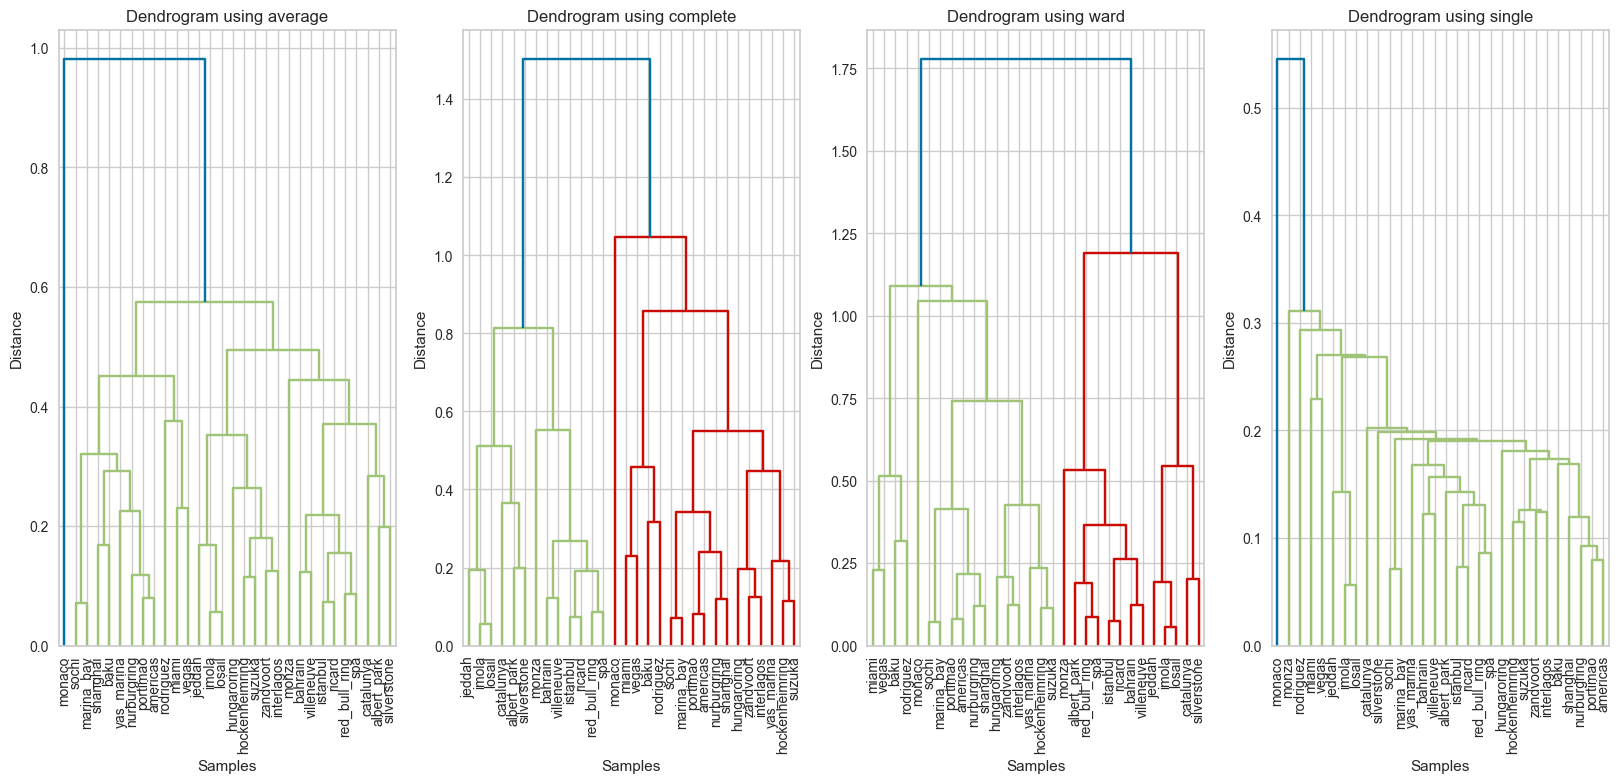

In [75]:
df_agg = df_kmeans.drop(columns='cluster').copy()

plot_dendrogram(df_agg)

The dendrograms do not seem to provide much information for clustering.

### 4.2.2 Agglomerative models and metrics

 Let's build an agglomerative clustering model, searching for the best model based on a combination of metrics: `silhouette_score`, `davies_bouldin_index`, and `balance_score`.

In [93]:
results_df = agglomerative_methods(df_agg)

best_model = results_df.sort_values(by='ranking_score', ascending=False).iloc[0]

Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=cosine: cosine was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.
Error with linkage=ward, metric=chebyshev: chebyshev was provided as metric. Ward can only work with euclidean distances.


In [94]:
best_model

linkage                       complete
metric                          cosine
silhouette_score              0.839172
davies_bouldin_index          0.521362
cluster_cardinality     {0: 17, 1: 13}
n_cluster                            2
balance_score                 1.307692
ranking_score                -0.989882
Name: 4, dtype: object

In [86]:
model = AgglomerativeClustering(
    linkage=best_model['linkage'],
    metric=best_model['metric'],
    distance_threshold=None,
    n_clusters=best_model['n_cluster']
)

agglo_fit = model.fit(df_agg)
agglo_labels = agglo_fit.labels_

clustering_metrics(df_agg, agglo_labels)

,silhouette_score,davies_bouldin_index,cardinality
0,0.645976,0.521362,17
1,0.645976,0.521362,13


The best model provides 2 clusters with cardinalities of 17 and 13. The `silhouette score` and `Davies-Bouldin index` metrics are quite good. Let's see how the clusters have been distributed.

### 4.2.3 Results

In [80]:
df_agg['cluster'] = agglo_labels

df_agg.sort_values(by='cluster')['cluster']

hockenheimring    0
yas_marina        0
vegas             0
rodriguez         0
americas          0
marina_bay        0
baku              0
zandvoort         0
hungaroring       0
monaco            0
miami             0
interlagos        0
suzuka            0
nurburgring       0
portimao          0
sochi             0
shanghai          0
imola             1
losail            1
istanbul          1
ricard            1
monza             1
jeddah            1
albert_park       1
silverstone       1
red_bull_ring     1
catalunya         1
spa               1
bahrain           1
villeneuve        1
Name: cluster, dtype: int64

In [89]:
plot_radar(df_agg, columns = df_agg.drop(columns='cluster').columns, opacity=0.8)

In this case, it seems clear that the clustering separates the circuits into one group with many slow corners, few straights, and moderate speed, and another group with fewer slow corners, many straights, and higher speed. In other words, into fast and slow circuits.

## 4.3 DBSCAN Clustering

We can also try DBSCAN clustering. To do this, we need to find the appropriate values for epsilon and min_samples. Let's run some tests.

Let's test with the entire scaled dataset, without removing any columns.

In [73]:
dbscan_methods(df_scaled, eps_values=[i/10 for i in range(1,20, 2)], min_samples_values=[1, 2, 3]).head()

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
12,0.9,1,0.412087,0.406533,"{0: 29, 1: 1}"
14,0.9,3,0.412087,0.406533,"{-1: 1, 0: 29}"
13,0.9,2,0.412087,0.406533,"{-1: 1, 0: 29}"
10,0.7,2,0.292304,1.262394,"{-1: 3, 0: 27}"
11,0.7,3,0.292304,1.262394,"{-1: 3, 0: 27}"


In this case, the dimensionality might be too high for the distance calculations to yield meaningful results. Let's try using the dataset with the selected columns.

In [97]:
dbscan_methods(df_kmeans.drop(columns='cluster'), eps_values=[i/10 for i in range(1,20, 2)], min_samples_values=[1, 2, 3]).head()

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
6,0.5,1,0.462966,0.355685,"{0: 29, 1: 1}"
7,0.5,2,0.462966,0.355685,"{-1: 1, 0: 29}"
8,0.5,3,0.462966,0.355685,"{-1: 1, 0: 29}"
4,0.3,2,0.373292,5.051440,"{-1: 2, 0: 28}"
5,0.3,3,0.373292,5.051440,"{-1: 2, 0: 28}"


As we can see, we do not obtain clusters with good cardinality, as two clusters are generated: one with 29 elements and another with just 1 element. This isolated element is likely the `Monaco` circuit, as it has a significant difference compared to the rest, and the DBSCAN method isolates it.

We can experiment with smaller epsilon values to further segment the larger cluster.

In [109]:
dbscan_methods(df_kmeans.drop(columns='cluster'), eps_values=[i/75 for i in range(1,20, 2)], min_samples_values=[1, 2, 3]).head()

,eps,min_samples,silhouette_score,davies_bouldin_score,cardinality
18,0.173333,1,0.267452,0.450893,"{0: 4, 1: 5, 2: 2, 3: 8, 4: 3, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1}"
15,0.146667,1,0.232835,0.402847,"{0: 4, 1: 4, 2: 2, 3: 5, 4: 2, 5: 3, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1}"
12,0.120000,1,0.207471,0.283988,"{0: 2, 1: 4, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 1, 10: 1, 11: 1, 12: 2, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1}"
19,0.173333,2,0.197828,2.312221,"{-1: 8, 0: 4, 1: 5, 2: 2, 3: 8, 4: 3}"
9,0.093333,1,0.183383,0.228536,"{0: 1, 1: 3, 2: 2, 3: 2, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 2, 11: 1, 12: 1, 13: 1, 14: 2, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1}"


However, we quickly reach a point where the clusters become too fragmented or we simply do not obtain good metrics.